### Preliminaries: importing packages

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import t
from itertools import product

from numba import njit
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
import os

if not os.path.exists('/content/E-PINN-Bergman'):
    !git clone https://github.com/HaiSiong-Tan/E-PINN-Bergman.git
    
MODEL_DIR = '/content/E-PINN-Bergman/EPINN_bergman/models'
DATA_DIR = '/content/E-PINN-Bergman/EPINN_bergman/data'

import sys
sys.path.append('/content/E-PINN-Bergman/EPINN_bergman/src')
import bergman_helpers

### Data

📂 Data

The glucose-insulin dataset used in this project was **digitized from Fig. 1** in:

> A. Kartono et al. (2019). *A mathematical model of the intravenous glucose tolerance test illustrating an $n$-order decay rate of plasma insulin in healthy and type 2 diabetic subjects*.  
> IOP Conference Series: Materials Science and Engineering, 532, 012016.  
> DOI: 10.1088/1757-899X/532/1/012016

Users should note that the data was extracted from the figure and may not exactly match the original measurements.

In [3]:
# Data obtained by using WebplotDigitizer on Kartono's paper (ref. 16)
glucose_csv_path = f"{DATA_DIR}/Kartono_subject_6_glucose.csv"
insulin_csv_path = f"{DATA_DIR}/Kartono_subject_6_insulin.csv"

In [4]:
glucose_df = pd.read_csv(glucose_csv_path, header = None)
glucose_df.columns = ["time", "glucose"]

insulin_df = pd.read_csv(insulin_csv_path, header = None)
insulin_df.columns = ["time", "insulin"]

g_time = glucose_df["time"].to_numpy()
glucose = glucose_df["glucose"].to_numpy()

i_time = insulin_df["time"].to_numpy()
insulin = insulin_df["insulin"].to_numpy()

i_index = np.argsort(i_time)
g_index = np.argsort(g_time)

# Observed insulin datapoints
insulin_time = i_time[i_index]
insulin_val = 1e-3*insulin[i_index]

# Observed glucose datapoints
glucose_time = g_time[g_index]
glucose_val = glucose[g_index]/250

# Some parameter estimates from Kartono et al. (2018)
G_b = 80/250
I_b = 50*1e-3
p_1 = 0.025  # units: [ min^{-1} ]
p_2 = 0.075  # units: [ min^{-1} ]
S_I = 5.5e-5 # units: [ (\mu U/ml)^{-1} min^{-1} ]
p_3 = p_2*S_I*1e3

t_I = insulin_time

I_of_t = interp1d(t_I, insulin_val, kind="linear", bounds_error=False,
                  fill_value=(insulin_val[0], insulin_val[-1]))

I_ext = torch.tensor(I_of_t(glucose_time)) - I_b  # interpolated values of insulin at times at which glucose was measured

### [A]Data-Fitting phase

In [ ]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(137)

nn_I = bergman_helpers.eFCN(1,32,2).to(device)    # using a two-hidden-layer perceptron for the base model

# learning rate and schedule: details can be adjusted based on loss functions' evolutions during training
lr=1e-3

def lr_lambda(epoch):
  if epoch < 20e3:
    return 1.0
  elif epoch < 40e3:
    return 0.1
  elif epoch < 50e3:
    return 0.01
  else:
    return 0.001

# defining various lists to keep track of various loss terms during model training
loss_list = []
data_loss_list = []
initial_loss_list = []
uncertainty_loss_list = []

# time input variable 't_z'
t_z = torch.tensor(glucose_time, dtype=torch.float32)
t_z = t_z.view(-1,1).requires_grad_(True)
t_z = t_z.to(device)


In [ ]:
# adjust this loss weight such that it's sufficient for model's predicted glucose curve to start at roughly the same value as the observed data.
coeff_ini = 1e8
n_D = len(t_z)    # number of training datapoints

optimizer = optim.Adam( list(nn_I.parameters()), lr=lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Training loop
for epoch in range(300_001):

    optimizer.zero_grad()

    #-----Data Loss----------------------------------------
    Lalpha, Lbeta, Lnu, L_glucose, L_X = nn_I(t_z)

    data_loss = n_D*bergman_helpers.evidential_data_loss(L_glucose, torch.tensor(glucose_val).view(-1,1), Lnu, Lalpha, Lbeta)

    #-----Imposing Initial Condition-----------------------
    initial_condition_X_loss= torch.mean((L_X[0] - 0.0)**2)

    #-----Total Loss---------------------------------------
    loss = data_loss + coeff_ini*initial_condition_X_loss

    #-----Backpropagation----------------------------------
    loss.backward()
    optimizer.step()
    scheduler.step()

    # (optional) Print loss every 5000 epochs
    if epoch % 5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}, data: {data_loss.item():.5e}, initial: {initial_condition_X_loss.item():.5e}")
        loss_list.append(loss.item())
        data_loss_list.append(data_loss.item())
        initial_loss_list.append(initial_condition_X_loss.item())
    # (optional) Plotting predicted curve every 10_000 epochs
    if epoch % 10_000 == 0:
        n_L_glucose = L_glucose.detach().cpu().numpy()
        n_L_X = L_X.detach().cpu().numpy()
        # computing confidence bands
        interval_CI = 0.95
        n_L_alpha = np.squeeze(Lalpha.detach().cpu().numpy())
        n_L_beta = np.squeeze(Lbeta.detach().cpu().numpy())
        n_L_nu = np.squeeze(Lnu.detach().cpu().numpy())
        Llower = np.squeeze(n_L_glucose) + bergman_helpers.CI_calculation(interval_CI, n_L_alpha, n_L_beta, n_L_nu, n_L_glucose)
        Lupper = np.squeeze(n_L_glucose) - bergman_helpers.CI_calculation(interval_CI, n_L_alpha, n_L_beta, n_L_nu, n_L_glucose)
        #------plotting---------------------------------------
        fig, axes = plt.subplots(1, 2, figsize=(9, 4))
        axes[0].scatter(glucose_time, glucose_val, marker='*', label = 'scaled Data')
        axes[0].set_xlabel("Time")
        axes[0].set_ylabel("Glucose")
        axes[0].plot(glucose_time, np.squeeze(n_L_glucose), 'r--', label='G(t) model')
        axes[0].fill_between(glucose_time, Llower, Lupper, facecolor='orange', alpha=0.2, label = rf'{interval_CI} C.I.')
        axes[0].legend()
        axes[1].plot(glucose_time, np.squeeze(n_L_X))
        axes[1].set_ylabel("X")
        plt.tight_layout()
        plt.show()
        plt.close()


In [ ]:
#saving model and training statistics
torch.save(nn_I.state_dict(), f'{MODEL_DIR}/initial_model.pth')
torch.save({
    'loss_list': loss_list,
    'data_loss_list': data_loss_list,
    'initial_loss_list': initial_loss_list,
          }, f'{MODEL_DIR}/initial_loss_lists.pth')


### [B]Intermediate phase

##### loading data-fitted model

In [ ]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_I = bergman_helpers.eFCN(1,32,2).to(device)
nn_I.load_state_dict(torch.load(f'{MODEL_DIR}/initial_model.pth'))

checkpoint = torch.load(f'{MODEL_DIR}/initial_loss_lists.pth')
loss_list = checkpoint['loss_list']
data_loss_list = checkpoint['data_loss_list']

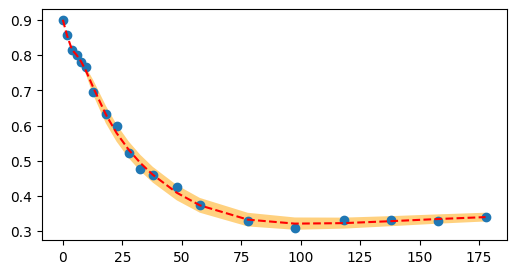

In [ ]:
t_z = torch.tensor(glucose_time, dtype=torch.float32)
t_z = t_z.view(-1,1).requires_grad_(True)
t_z = t_z.to(device)
t_glucose_val = torch.tensor(glucose_val, dtype=torch.float32)

#plotting initial model's prediction
Lalpha, Lbeta, Lnu, L_glucose, L_X = nn_I(t_z)
n_L_glucose = L_glucose.detach().cpu().numpy()
interval_CI = 0.95
n_L_alpha = np.squeeze(Lalpha.detach().cpu().numpy())
n_L_beta = np.squeeze(Lbeta.detach().cpu().numpy())
n_L_nu = np.squeeze(Lnu.detach().cpu().numpy())
Llower = np.squeeze(n_L_glucose) + bergman_helpers.CI_calculation(interval_CI, n_L_alpha, n_L_beta, n_L_nu, n_L_glucose)
Lupper = np.squeeze(n_L_glucose) - bergman_helpers.CI_calculation(interval_CI, n_L_alpha, n_L_beta, n_L_nu, n_L_glucose)

plt.figure(figsize=(6, 3))
plt.plot(glucose_time, np.squeeze(L_glucose.detach().cpu().numpy()), 'r--', label='Data-fitted model')
plt.fill_between(glucose_time, Llower, Lupper, facecolor='orange', alpha=0.5, label = rf'{interval_CI} C.I.')
plt.scatter(glucose_time, glucose_val)

##### constructing the parameter prior

In [ ]:
# --- Time span & output grid ---
t_start, t_end = 0, 200
t_eval_out = glucose_time

# --- Initial conditions ---
y0 = [glucose_val[0], 0.0]

# --- Parameter domains ---
p1_vals = np.linspace(1e-4, 1e-1, 40)
p2_vals = np.linspace(1e-3, 0.10, 40)
p3_vals = np.linspace(1e-5, 1e-2, 40)


# --- numerically solving Bergman equations for all p1,p2,p3 within their domains
# --- all solutions saved in the dictionary named 'results'
results = {}

for p1, p2, p3 in product(p1_vals, p2_vals, p3_vals):

    p = (p1, p2, p3, G_b, I_b)
    sol = solve_ivp(lambda t, y: bergman_helpers.bergman_rhs(t, y, p, I_of_t),
                    (t_start, t_end), y0,
                    rtol=1e-6, atol=1e-8, max_step=1.0,
                    dense_output=True)

    # evaluate on all the times of glucose measurements
    G_new, X_new = sol.sol(t_eval_out)

    results[(p1, p2, p3)] = (G_new, X_new)

print(f"Stored {len(results)} simulations, each on {len(t_eval_out)} time points")

# Constructing the empirical density function $f(\Omega)$: its highest density region is used to construct prior for the unknown PDE parameters.
msd_list = []
initial_model_glucose_val = np.squeeze(L_glucose.detach().cpu().numpy())
for p1 in p1_vals:
    for p2 in p2_vals:
        for p3 in p3_vals:
            numerical_sol = results[(p1, p2, p3)][0]
            msd = np.sum((numerical_sol - initial_model_glucose_val)**2)
            msd_list.append(msd)

var_HDR = np.mean(msd_list)
mse = np.exp(-0.5*np.array(msd_list)/var_HDR)

prob_grid = np.array(mse).reshape(len(p1_vals), len(p2_vals), len(p3_vals))

#np.save(f"{MODEL_DIR}/sub6_prior_prob_grid.npy", prob_grid)

#prob_grid = np.load(f"{MODEL_DIR}/sub6_prior_prob_grid.npy")


💡 Use this cell if you have previously completed the first phase of training and generated and saved prob_grid

```python
p1_vals = np.linspace(1e-4, 1e-1, 40)
p2_vals = np.linspace(1e-3, 0.10, 40)
p3_vals = np.linspace(1e-5, 1e-2, 40)

prob_grid = np.load(f"{MODEL_DIR}/sub6_prior_prob_grid.npy")
```

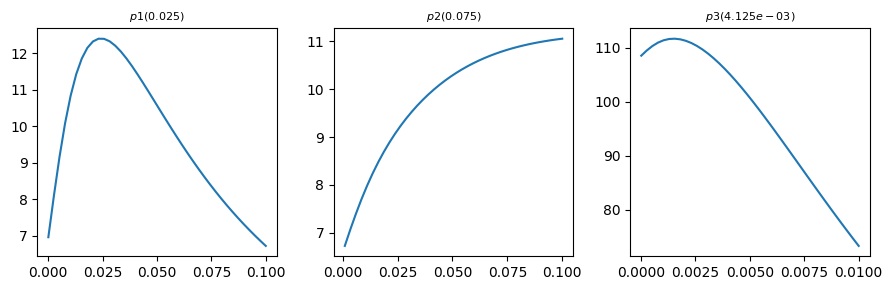

In [ ]:
#Visualizing marginal distributions from the parameter prior
x0_marginal, x1_marginal, x2_marginal = bergman_helpers.three_marginal_prior(prob_grid,  p1_vals, p2_vals, p3_vals)

fig, axes = plt.subplots(1,3, figsize = (9,3))
axes[0].plot(p1_vals, x0_marginal)
axes[0].set_title(rf'$p1 ({p_1:.3f})$', fontsize = 8)
axes[1].plot(p2_vals, x1_marginal)
axes[1].set_title(rf'$p2 ({p_2:.3f})$', fontsize = 8)
axes[2].plot(p3_vals, x2_marginal)
axes[2].set_title(rf'$p3 ({p_3:.3e})$', fontsize = 8)
plt.tight_layout()

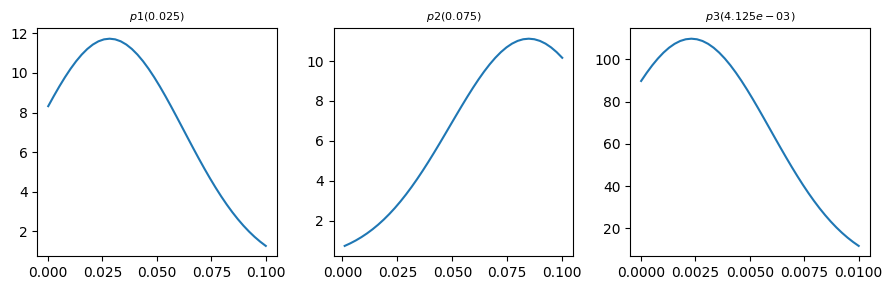

In [ ]:
p1_prior_mean, p2_prior_mean, p3_prior_mean, p1_prior_std, p2_prior_std, p3_prior_std \
= bergman_helpers.three_stats_prior(prob_grid, p1_vals, p2_vals, p3_vals)

p1_prior = bergman_helpers.uni_gaussian(p1_vals, p1_prior_mean, p1_prior_std)
p2_prior = bergman_helpers.uni_gaussian(p2_vals, p2_prior_mean, p2_prior_std)
p3_prior = bergman_helpers.uni_gaussian(p3_vals, p3_prior_mean, p3_prior_std)

fig, axes = plt.subplots(1,3, figsize = (9,3))
axes[0].plot(p1_vals, p1_prior)
axes[0].set_title(rf'$p1 ({p_1:.3f})$', fontsize = 8)
axes[1].plot(p2_vals, p2_prior)
axes[1].set_title(rf'$p2 ({p_2:.3f})$', fontsize = 8)
axes[2].plot(p3_vals, p3_prior)
axes[2].set_title(rf'$p3 ({p_3:.3e})$', fontsize = 8)
plt.tight_layout()

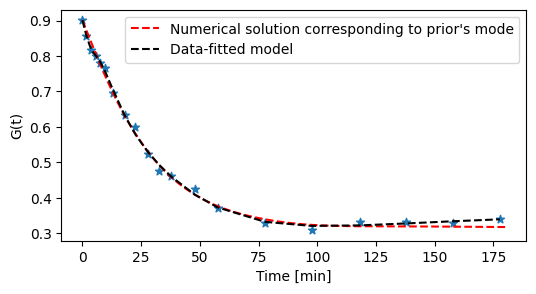

In [ ]:
# Visualizing the mode of the prior distribution

def bergman_plot(p1, p2, p3, Gb, Ib, tend=180):
    """
    Generates the numerical solution to Bergman equation for p1, p2, p3

    Args: (NumPy arrays)
        p1,p2,p3: the parameters of Bergman equations
        Gb: the basal glucose level
        Ib: the basal insulin level

    Returns: (NumPy arrays)
        t: time
        G: glucose
    """

    theta = (p1, p2, p3, Gb, Ib)
    t_start, t_end = 0.0, tend  # minutes
    t_eval = np.linspace(t_start, t_end, 800)
    y0 = [glucose_val[0], 0.0]

    sol = solve_ivp(lambda t, y: bergman_helpers.bergman_rhs(t, y, theta, I_of_t),
                    (t_start, t_end), y0, t_eval=t_eval,
                    rtol=1e-6, atol=1e-8, max_step=1.0)
    t = sol.t
    G = sol.y[0]
    X = sol.y[1]
    return t,G

t,G = bergman_plot(p1_prior_mean, p2_prior_mean, p3_prior_mean, G_b, I_b)

plt.figure(figsize=(6, 3))
plt.plot(t, G, 'r--', label="Numerical solution corresponding to prior's mode")
plt.plot(glucose_time, np.squeeze(L_glucose.detach().cpu().numpy()), 'k--', label='Data-fitted model')
plt.scatter(glucose_time, glucose_val, marker='*')
plt.xlabel("Time [min]")
plt.ylabel("G(t)")
plt.legend()
plt.show()

##### constructing the prior for the loss weight of the PDE residual term

In [ ]:
G_alpha, G_beta, G_nu, G_pred, G_X = nn_I(t_z)

dG_dt = torch.autograd.grad(G_pred, t_z,
                                  grad_outputs=torch.ones_like(G_pred), create_graph=True)[0]
n_dG_dt = np.squeeze(dG_dt.detach().cpu().numpy())

dX_dt = torch.autograd.grad(G_X, t_z,
                                  grad_outputs=torch.ones_like(G_X), create_graph=True)[0]
n_dX_dt = np.squeeze(dX_dt.detach().cpu().numpy())

n_G_pred = np.squeeze(G_pred.detach().cpu().numpy())

n_G_X = np.squeeze(G_X.detach().cpu().numpy())

resi_sum = bergman_helpers.bergman_likelihood_array(p1_vals, p2_vals, p3_vals,
                                   n_dG_dt, n_G_pred, n_dX_dt, n_G_X, I_ext.detach().cpu().numpy(), G_b)

likelihood_function = np.sum(resi_sum, axis = -1)

Optimal beta: 1.9009e-03
Optimal beta: 4.2624e-05
Mean_var: 0.002, Min_var: 0.000
Alpha_s: 1.0459, Beta_s: 0.0001


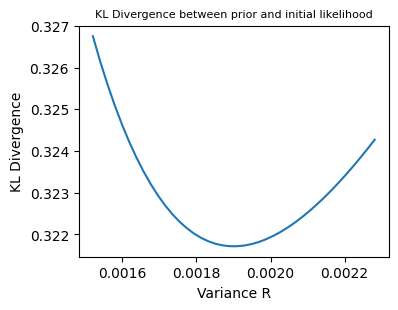

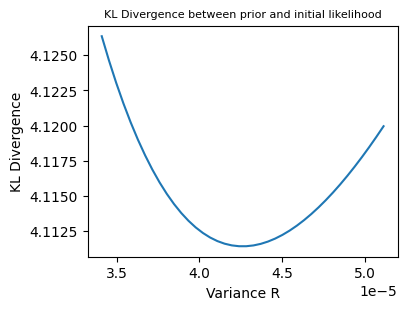

In [ ]:
#Computing KL divergence between para prior and initial likelihood

mean_var = bergman_helpers.mean_var_KL_3D(1e-4, likelihood_function, p1_prior, p2_prior, p3_prior)

reg_s = 1.4
M_p1 = reg_s*(p1_vals[2]-p1_vals[1])
M_p2 = reg_s*(p2_vals[2]-p2_vals[1])
M_p3 = reg_s*(p3_vals[2]-p3_vals[1])

l_p1_prior = bergman_helpers.uni_gaussian(p1_vals, p1_prior_mean, M_p1)
l_p2_prior = bergman_helpers.uni_gaussian(p2_vals, p2_prior_mean, M_p2)
l_p3_prior = bergman_helpers.uni_gaussian(p3_vals, p3_prior_mean, M_p3)

min_var = bergman_helpers.mean_var_KL_3D(1e-5, likelihood_function, l_p1_prior, l_p2_prior, l_p3_prior)

alpha, beta = bergman_helpers.PDE_prior(min_var, mean_var)

### [C]Second training phase

##### Model training

In [ ]:
prob_grid = np.load(f'{MODEL_DIR}/sub6_prior_prob_grid.npy')
# --- Parameter domains ---
p1_vals = np.linspace(1e-4, 1e-1, 40)
p2_vals = np.linspace(1e-3, 0.10, 40)
p3_vals = np.linspace(1e-5, 1e-2, 40)

p1_prior_mean, p2_prior_mean, p3_prior_mean, p1_prior_std, p2_prior_std, p3_prior_std \
= bergman_helpers.three_stats_prior(prob_grid, p1_vals, p2_vals, p3_vals)

In [ ]:
# Setting initial values

def inverse_sigmoid(y):
    """
    Returns the inverse of the sigmoid function.
    """
    return np.log(y / (1 - y))

n_D = len(glucose_time)

# To ensure positivity of learnable parameters p1, p2, p3, we equate each to the
# sigmoid of a corresponding auxiliary parameter.
p1_initial = inverse_sigmoid(p1_prior_mean)
p2_initial = inverse_sigmoid(p2_prior_mean)
p3_initial = inverse_sigmoid(p3_prior_mean)

s_initial = torch.tensor(mean_var)

In [ ]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loading data-fitted model that was trained in the first phase
torch.manual_seed(137)
nn_I = bergman_helpers.eFCN(1,32,2).to(device)
nn_I.load_state_dict(torch.load(f'{MODEL_DIR}/initial_model.pth'))

# learning rate and schedule
lr=1e-4
def lr_lambda(epoch):
  if epoch < 100_000:
    return 1.0
  else:
    return 0.1

# Initializing various lists to keep track of model training statistics
loss_list = []
data_loss_list = []
pde_loss_list = []
p1_list = []
p2_list = []
p3_list = []
initial_loss_list = []
s_list = []
pde_prior_list = []
para_prior_list = []
uncertainty_loss_list = []
loss_G_list = []
loss_X_list = []


In [ ]:
mse_loss = nn.MSELoss()
t_I_ext = torch.tensor(I_ext)

# Additional coefficients for each loss term in case further adjustments are needed for model convergence
coef_physics = 1.     #PDE residual loss term
coef_ini = 1e8        #Initial condition
coef_prior = 1.       #Prior for the variance parameter in the PDE residual loss term
coef_pp = 1.          #Parameter prior function

p1 = torch.nn.Parameter(torch.tensor(p1_initial, device=device, requires_grad=True))
p2 = torch.nn.Parameter(torch.tensor(p2_initial, device=device, requires_grad=True))
p3 = torch.nn.Parameter(torch.tensor(p3_initial, device=device, requires_grad=True))
s = torch.nn.Parameter(torch.tensor(s_initial, device=device, requires_grad=True))

optimizer = optim.Adam([p1, p2, p3, s] + list(nn_I.parameters()), lr=lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Training loop
for epoch in range(300_001):

    optimizer.zero_grad()
    p1_pos = torch.sigmoid(p1)
    p2_pos = torch.sigmoid(p2)
    p3_pos = torch.sigmoid(p3)

    #-----Data Loss-----------------------------------------
    Lalpha, Lbeta, Lnu, L_glucose, L_X = nn_I(t_z)

    data_loss = n_D*bergman_helpers.evidential_data_loss(L_glucose, torch.tensor(glucose_val).view(-1,1), Lnu, Lalpha, Lbeta)

    #-----PDE Loss-----------------------------------------

    dG_dz = torch.autograd.grad(L_glucose, t_z, grad_outputs=torch.ones_like(L_glucose), create_graph=True)[0]
    dX_dz = torch.autograd.grad(L_X, t_z, grad_outputs=torch.ones_like(L_X), create_graph=True)[0]

    mse_physics_loss_G = torch.sum(
                (dG_dz + p1_pos*(L_glucose - G_b) + L_X*L_glucose)**2
                                  )
    mse_physics_loss_X = torch.sum(
                (dX_dz + p2_pos*L_X - p3_pos*(I_ext))**2)

    mse_physics_loss = mse_physics_loss_G + mse_physics_loss_X

    pde_loss = 0.5*(1/s)*mse_physics_loss
    pde_prior_loss = (alpha + 3/2)*torch.log(s) + beta/s

    #-----Prior loss----------------------------------------
    neg_ll_p1_prior = (1/(2*torch.tensor(p1_prior_std)**2))*torch.mean((p1_pos - torch.tensor(p1_prior_mean))**2)
    neg_ll_p2_prior = (1/(2*torch.tensor(p2_prior_std)**2))*torch.mean((p2_pos - torch.tensor(p2_prior_mean))**2)
    neg_ll_p3_prior = (1/(2*torch.tensor(p3_prior_std)**2))*torch.mean((p3_pos - torch.tensor(p3_prior_mean))**2)
    para_prior_loss = neg_ll_p1_prior + neg_ll_p2_prior + neg_ll_p3_prior

    #-----Soft constraint for initial condition--------------
    initial_condition_X_loss= torch.mean((L_X[0] - 0.0)**2)

    #-----Total Loss-----------------------------------------
    loss = data_loss + coef_physics*pde_loss + coef_ini*initial_condition_X_loss \
            + coef_prior*pde_prior_loss + coef_pp*para_prior_loss


    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # (optional) Print loss every 1000 epochs, and visualize model prediction every 20_000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}, data: {data_loss.item():.5e}, pde: {pde_loss.item():.4e}")
        print(f"p1: {p1_pos.item():.5e}, p2: {p2_pos.item():.5e}, p3: {p3_pos.item():.5e}, prior: {pde_prior_loss.item():.5e}")
        loss_list.append(loss.item())
        data_loss_list.append(data_loss.item())
        pde_loss_list.append(pde_loss.item())
        pde_prior_list.append(pde_prior_loss.item())
        para_prior_list.append(para_prior_loss.item())
        p1_list.append(p1_pos.item())
        p2_list.append(p2_pos.item())
        p3_list.append(p3_pos.item())
        initial_loss_list.append(initial_condition_X_loss.item())
        s_list.append(s.item())
        loss_G_list.append(mse_physics_loss_G.item())
        loss_X_list.append(mse_physics_loss_X.item())

    if epoch % 20_000 == 0:
        n_L_glucose = L_glucose.detach().cpu().numpy()
        n_L_X = L_X.detach().cpu().numpy()
        t_p, G_p = bergman_plot(p1_pos.item(), p2_pos.item(), p3_pos.item(), G_b, I_b)
        interval_CI = 0.95
        n_L_alpha = np.squeeze(Lalpha.detach().cpu().numpy())
        n_L_beta = np.squeeze(Lbeta.detach().cpu().numpy())
        n_L_nu = np.squeeze(Lnu.detach().cpu().numpy())
        Llower = np.squeeze(n_L_glucose) + bergman_helpers.CI_calculation(interval_CI, n_L_alpha, n_L_beta, n_L_nu, n_L_glucose)
        Lupper = np.squeeze(n_L_glucose) - bergman_helpers.CI_calculation(interval_CI, n_L_alpha, n_L_beta, n_L_nu, n_L_glucose)

        fig, axes = plt.subplots(1, 2, figsize=(9, 4))
        axes[0].scatter(glucose_time, glucose_val, marker='*')
        axes[0].set_xlabel("Time")
        axes[0].set_ylabel("Glucose")
        axes[0].plot(t_p, G_p, 'b--', label="Numerical Bergman sol.")
        axes[0].plot(glucose_time, np.squeeze(n_L_glucose), 'r--', label='G(t) model')
        axes[0].fill_between(glucose_time, Llower, Lupper, facecolor='orange', alpha=0.2, label = rf'{interval_CI} C.I.')
        axes[0].legend()
        axes[1].plot(glucose_time, np.squeeze(n_L_X))
        axes[1].set_ylabel("X")
        plt.tight_layout()
        plt.show()
        plt.close()

In [ ]:
torch.save(nn_I.state_dict(), f'{MODEL_DIR}/final_model.pth')

torch.save({
    'loss_list': loss_list,
    'data_loss_list': data_loss_list,
    'pde_loss_list': pde_loss_list,
    'initial_loss_list': initial_loss_list,
    'p1_loss_list': p1_list,
    'p2_loss_list': p2_list,
    'p3_loss_list': p3_list,
    's_list': s_list,
    'pde_prior_list': pde_prior_list,
    'para_prior_list': para_prior_list,
    'loss_G_list': loss_G_list,
    'loss_X_list': loss_X_list,
}, f'{MODEL_DIR}/final_loss_lists.pth')


##### Convergence analysis after model training

In [ ]:
nn_I = bergman_helpers.eFCN(1,32,2).to(device)
nn_I.load_state_dict(torch.load(f'{MODEL_DIR}/final_model.pth'))
checkpoint = torch.load(f'{MODEL_DIR}/final_loss_lists.pth')
s_list = checkpoint['s_list']
p1_list = checkpoint['p1_loss_list']
p2_list = checkpoint['p2_loss_list']
p3_list = checkpoint['p3_loss_list']
pde_prior_list = checkpoint['pde_prior_list']
para__prior_list = checkpoint['para_prior_list']
loss_list = checkpoint['loss_list']
data_loss_list = checkpoint['data_loss_list']
pde_loss_list = checkpoint['pde_loss_list']
initial_loss_list = checkpoint['initial_loss_list']
loss_G_list = checkpoint['loss_G_list']
loss_X_list = checkpoint['loss_X_list']


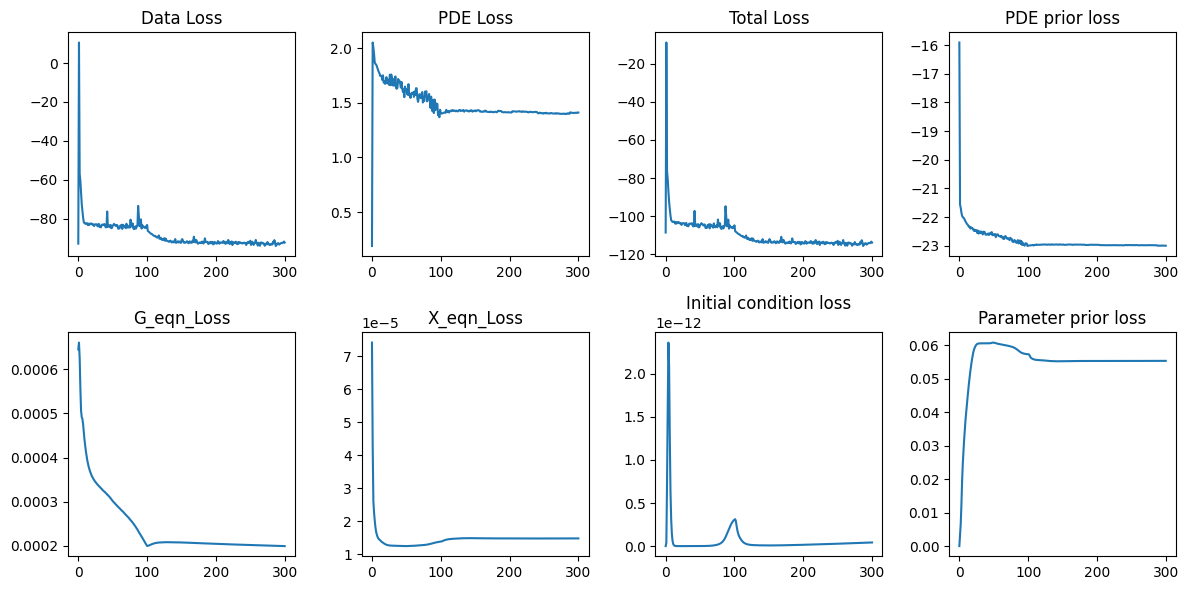

In [ ]:
# Visualizing various loss evolutions
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes[0,0].plot(data_loss_list)
axes[0,0].set_title('Data Loss')
axes[0,1].plot(pde_loss_list[:])
axes[0,1].set_title('PDE Loss')
axes[0,2].plot(loss_list[:])
axes[0,2].set_title('Total Loss')
axes[0,3].plot(pde_prior_list)
axes[0,3].set_title('PDE prior loss')

axes[1,0].plot(loss_G_list)
axes[1,0].set_title('G_eqn_Loss')
axes[1,1].plot(loss_X_list[:])
axes[1,1].set_title('X_eqn_Loss')
axes[1,2].plot(initial_loss_list[:])
axes[1,2].set_title('Initial condition loss')
axes[1,3].plot(para_prior_list)
axes[1,3].set_title('Parameter prior loss')
plt.tight_layout()

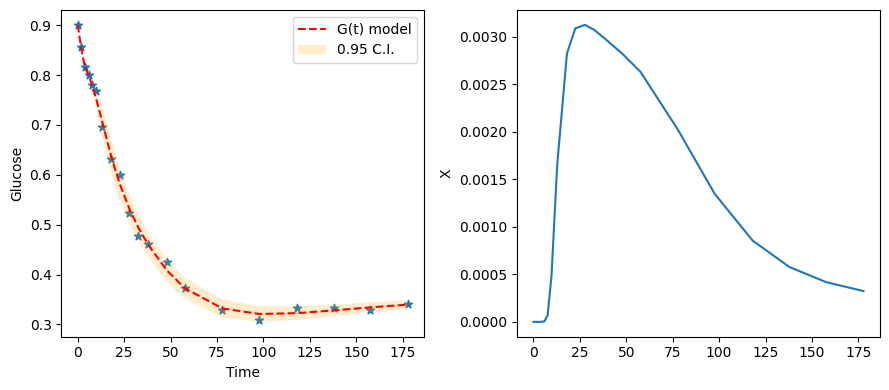

In [ ]:
#Visualizing model prediction
Lalpha, Lbeta, Lnu, L_glucose, L_X = nn_I(t_z)
n_L_glucose = L_glucose.detach().cpu().numpy()
n_L_X = L_X.detach().cpu().numpy()

interval_CI = 0.95
n_L_alpha = np.squeeze(Lalpha.detach().cpu().numpy())
n_L_beta = np.squeeze(Lbeta.detach().cpu().numpy())
n_L_nu = np.squeeze(Lnu.detach().cpu().numpy())
Llower = np.squeeze(n_L_glucose) + bergman_helpers.CI_calculation(interval_CI, n_L_alpha, n_L_beta, n_L_nu, n_L_glucose)
Lupper = np.squeeze(n_L_glucose) - bergman_helpers.CI_calculation(interval_CI, n_L_alpha, n_L_beta, n_L_nu, n_L_glucose)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
axes[0].scatter(glucose_time, glucose_val, marker='*')
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Glucose")
axes[0].plot(glucose_time, np.squeeze(n_L_glucose), 'r--', label='G(t) model')
axes[0].fill_between(glucose_time, Llower, Lupper, facecolor='orange', alpha=0.2, label = rf'{interval_CI} C.I.')
axes[0].legend()
axes[1].plot(glucose_time, np.squeeze(n_L_X))
axes[1].set_ylabel("X")
plt.tight_layout()
plt.show()

In [ ]:
# Relative tolerance metric for loss functions
def rel_tol_generator(list):
  rel_tol = []
  for i in range(1,len(list)):
      rel_tol.append((list[i] - list[i-1])/list[i-1])
  return rel_tol

rel_data_tol = rel_tol_generator(loss_list)

plt.plot(rel_data_tol[10:])

### Analysis and parameter inference

In [ ]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_I = bergman_helpers.eFCN(1,32,2).to(device)
nn_I.load_state_dict(torch.load(f'{MODEL_DIR}/final_model.pth'))
checkpoint = torch.load(f'{MODEL_DIR}/final_loss_lists.pth')
s_list = checkpoint['s_list']
p1_list = checkpoint['p1_loss_list']
p2_list = checkpoint['p2_loss_list']
p3_list = checkpoint['p3_loss_list']


In [ ]:
prob_grid = np.load(f'{MODEL_DIR}/sub6_prior_prob_grid.npy')
# --- Parameter domains ---
p1_vals = np.linspace(1e-4, 1e-1, 40)
p2_vals = np.linspace(1e-3, 0.10, 40)
p3_vals = np.linspace(1e-5, 1e-2, 40)

p1_prior_mean, p2_prior_mean, p3_prior_mean, p1_prior_std, p2_prior_std, p3_prior_std \
= bergman_helpers.three_stats_prior(prob_grid, p1_vals, p2_vals, p3_vals)

In [ ]:
# Time input
t_z = torch.tensor(glucose_time, dtype=torch.float32)
t_z = t_z.view(-1,1).requires_grad_(True)
t_z = t_z.to(device)

# Prediction by final model
Lalpha, Lbeta, Lnu, L_glucose, L_X = nn_I(t_z)

dG_dz = torch.autograd.grad(L_glucose, t_z, grad_outputs=torch.ones_like(L_glucose), create_graph=True)[0]
dX_dz = torch.autograd.grad(L_X, t_z, grad_outputs=torch.ones_like(L_X), create_graph=True)[0]

grad_G = np.squeeze(dG_dz.detach().cpu().numpy())
nL_glucose = np.squeeze(L_glucose.detach().cpu().numpy())
grad_X = np.squeeze(dX_dz.detach().cpu().numpy())
nL_X = np.squeeze(L_X.detach().cpu().numpy())

#---Deriving the posterior distribution ----------------------------------------
resi_sum = bergman_helpers.bergman_likelihood_array(p1_vals, p2_vals, p3_vals, grad_G, nL_glucose, grad_X,
                             nL_X, I_ext.detach().cpu().numpy(), G_b)

likelihood_function = np.sum(resi_sum, axis = -1)

obj = bergman_helpers.njit_marginal_ll(s_list[-1], likelihood_function)

p1_prior = bergman_helpers.uni_gaussian(p1_vals, p1_prior_mean, p1_prior_std)
p2_prior = bergman_helpers.uni_gaussian(p2_vals, p2_prior_mean, p2_prior_std)
p3_prior = bergman_helpers.uni_gaussian(p3_vals, p3_prior_mean, p3_prior_std)

posterior_dis = bergman_helpers.posterior_array_3D(obj, p1_prior, p2_prior, p3_prior, p1_vals, p2_vals, p3_vals)

In [ ]:
# Generating samples of p1,p2,p3 from the posterior distribution

posterior_norm = posterior_dis / np.sum(posterior_dis)
p1_marginal = np.sum(posterior_norm, axis=(1,2))
p2_marginal = np.sum(posterior_norm, axis=(0,2))
p3_marginal = np.sum(posterior_norm, axis=(0,1))

posterior_flat = posterior_norm.ravel()
grid_shape = posterior_dis.shape

n_samples = 500_000
flat_indices = np.random.choice(len(posterior_flat), size=n_samples, p=posterior_flat)
multi_indices = np.array(np.unravel_index(flat_indices, grid_shape)).T

p1_samples = p1_vals[multi_indices[:, 0]]
p2_samples = p2_vals[multi_indices[:, 1]]
p3_samples = p3_vals[multi_indices[:, 2]]

para_samples = np.zeros([n_samples,3])
para_samples[:,0] = p1_samples
para_samples[:,1] = p2_samples
para_samples[:,2] = p3_samples

#### Corner plots for the inferred parameters and a couple of indices derived from them

In [ ]:
!pip install corner
import corner

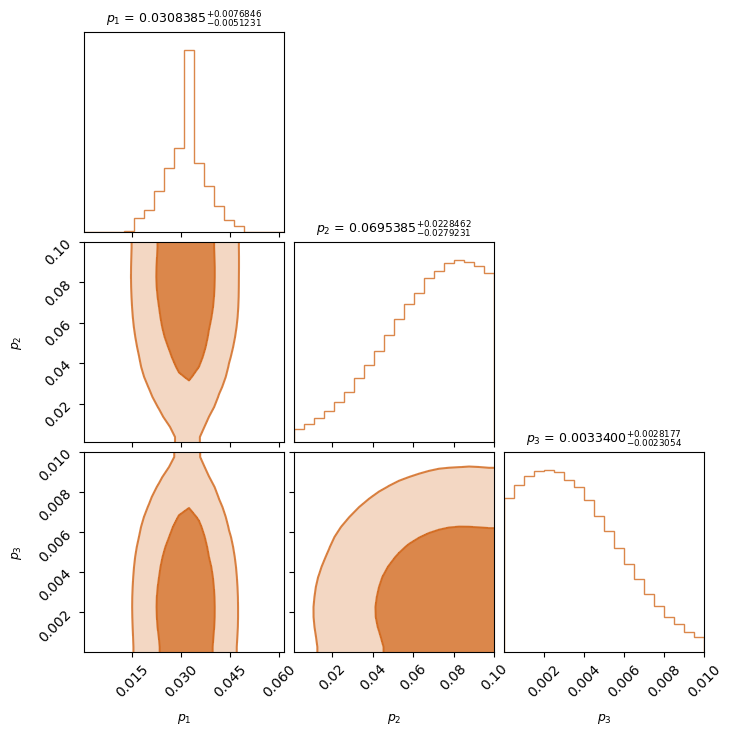

In [ ]:
brown_soft = mcolors.to_rgba("chocolate", alpha=0.8)
fig = corner.corner(
    para_samples,
    labels=[r"$p_1$", r"$p_2$", r"$p_3$"],label_kwargs={"fontsize": 9},
    show_titles=True,
    title_fmt=".7f",
    title_kwargs={"fontsize": 9},
    levels=[0.68, 0.95],
    fill_contours=True,
    plot_datapoints=False,
    smooth=1.0,
    color=brown_soft
)

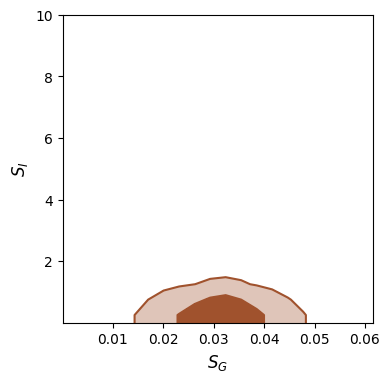

In [ ]:
# Glucose effectiveness (p1), Insulin sensitivity index (p3/p2)
insulin_sensitivity = p3_samples/p2_samples
index_samples = np.zeros([n_samples,2])
index_samples[:,0] = p1_samples
index_samples[:,1] = insulin_sensitivity

fig, ax = plt.subplots(figsize=(4,4))
corner.hist2d(
    index_samples[:, 0],
    index_samples[:, 1],
    bins=20,
    ax=ax,
    color="sienna",
    plot_datapoints=False,
    plot_density=True,
    fill_contours=True,
    smooth=1.0,
    levels=[0.68, 0.95]
)

ax.set_xlabel(r"$S_G$", fontsize=12)
ax.set_ylabel(r"$S_I$", fontsize=12)

plt.show()

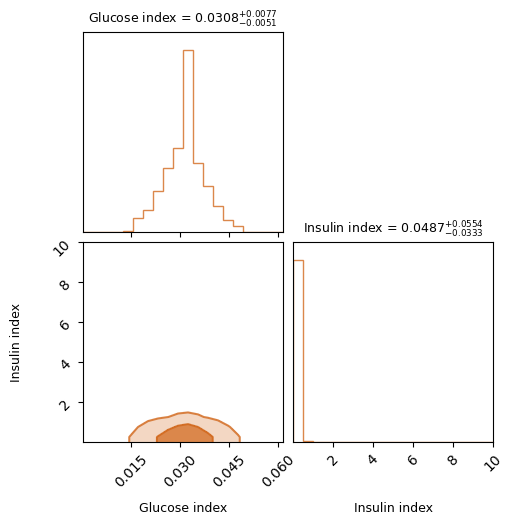

In [ ]:
fig = corner.corner(
    index_samples,
    labels=["Glucose index", "Insulin index"],label_kwargs={"fontsize": 9},
    show_titles=True,
    title_fmt=".4f",
    title_kwargs={"fontsize": 9},
    levels=[0.68, 0.95],
    fill_contours=True,
    plot_datapoints=False,
    smooth=1.0,
    color=brown_soft
)